# R Post-Processing of RocketLogger Indoor Harvesting Traces

```
Copyright (c) 2019-2020, ETH Zurich, Computer Engineering Group
All rights reserved.

This work is licensed under the Creative Commons Attribution 4.0 International License.
To view a copy of this license, visit http://creativecommons.org/licenses/by/4.0/ or
send a letter to Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.
```

The file is part of the dataset entiled *"Long-Term Tracing of Indoor Solar Harvesting"* which complements the following publication:

> L. Sigrist, A. Gomez, and L. Thiele.
> *"Dataset: Tracing Indoor Solar Harvesting."*
> In Proceedings of the 2nd Workshop on Data Acquisition To Analysis (DATA '19), 2019.


The dataset is published and documented on Zenodo:

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3715472.svg)](https://doi.org/10.5281/zenodo.3715472)

**Description**

This R notebook imports the processed HDF5 dataset of the *Indoor Solar Harvesting Dataset* stored in the [`processed/`](processed/) folder. After calculating additional power and energy data columns, time series object are generated and aggregated in 5 min intervals.
The remainer of the notebook provides an DC-DC conversion efficiency analysis of the bq25505 harvesting chip, and analyzes the harvested energy as a function of the ambient light level.

**R package requirements**

The following R packages are required to run this script: `data.table h5 xts zoo`

In [1]:
library(data.table)
library(xts)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘xts’


The following objects are masked from ‘package:data.table’:

    first, last




## Import Processed Dataset

In [2]:
DATASET_PATH <- './processed'
DATASET_POSITIONS <- c('pos06', 'pos13', 'pos14', 'pos16', 'pos17', 'pos18')
DATASET_TIME_REFERENCE <- 'relative' # see raw data import script for more explaination

In [3]:
# load dataset helper function using h5 package (deprecated in favor of hdf5r, but currently still much faster)
load.dataset.h5 <- function(filename) {
    library(h5)
    file.h5 <- h5file(filename, mode = 'r')
    timestamp_ns <- file.h5['dataset/axis1'][]
    dataset.columns <- file.h5['dataset/block0_items'][]
    dataset.values <- file.h5['dataset/block0_values'][]
    h5close(file.h5)
    
    # assemble data table and derive energy columns
    dataset.table <- data.table(dataset.values)
    colnames(dataset.table) <- dataset.columns
    
    dataset.time <- as.POSIXct(timestamp_ns * 1e-9, origin = '1970-01-01', tz = 'UTC')
    
    return(list('data' = dataset.table, 'time' = dataset.time))
}

In [4]:
# load dataset for the first position
position <- DATASET_POSITIONS[1]

power <- load.dataset.h5(file.path(DATASET_PATH, paste(position, '_power_', DATASET_TIME_REFERENCE, '.h5', sep = '')))
sensor <- load.dataset.h5(file.path(DATASET_PATH, paste(position, '_sensor_', DATASET_TIME_REFERENCE, '.h5', sep = '')))

In [5]:
# derive energy and average sensor columns
power$data[ , P_in := -1 * V_in * I_in]
power$data[ , E_in := P_in * dt]
power$data[ , P_bat := V_bat * I_bat]
power$data[ , E_bat := P_bat * dt]

sensor$data[ , Ev := Ev_left + Ev_right / 2]

In [6]:
# create time series from dataset
power.ts <- zoo(power$data, order.by = power$time)
sensor.ts <- zoo(sensor$data, order.by = sensor$time)

# cleanup temporary imported data table
rm(power, sensor)

## Dataset Aggregation

In [7]:
# aggregation time window in seconds
AGGREGATE_WINDOW <- 300 # seconds

In [8]:
# aggregate power data with time alignment
t.aligned <- align.time(as.xts(power.ts), n = AGGREGATE_WINDOW)
power.agg.m <- aggregate(power.ts[, c('I_bat', 'I_in', 'V_bat', 'V_in', 'P_in', 'P_bat')], by = time(t.aligned), FUN = mean, regular = TRUE)
power.agg.s <- aggregate(power.ts[, c('E_in', 'E_bat')], by = time(t.aligned), FUN = sum, regular = TRUE)
power.agg.c <- aggregate(power.ts[, c('dt')], by = time(t.aligned), FUN = length, regular = TRUE)
power.agg <- cbind(power.agg.m, power.agg.s, count = power.agg.c)

# cleanup temporary aggregates
rm(power.agg.m, power.agg.s, power.agg.c)

In [9]:
# aggregate sensor data with time alignment
t.aligned <- align.time(as.xts(sensor.ts), n = AGGREGATE_WINDOW)
sensor.agg.m <- aggregate(sensor.ts[, c('Ev_left', 'Ev_right', 'P_amb', 'RH_amb', 'T_amb', 'Ev')], by = time(t.aligned), FUN = mean, regular = TRUE)
sensor.agg.c <- aggregate(sensor.ts[, c('dt')], by = time(t.aligned), FUN = length, regular = TRUE)
sensor.agg <- cbind(sensor.agg.m, count = sensor.agg.c)

# cleanup temporary aggregates
rm(sensor.agg.m, sensor.agg.c)

## Dataset Summary

In [10]:
# print power dataset overview
summary(power.ts)
summary(power.agg)

     Index                         I_bat                 I_in           
 Min.   :2017-07-27 13:29:07   Min.   :-4.366e-05   Min.   :-8.491e-05  
 1st Qu.:2018-01-18 03:59:51   1st Qu.:-5.883e-07   1st Qu.:-3.260e-05  
 Median :2018-07-10 14:12:39   Median :-4.434e-07   Median :-6.418e-07  
 Mean   :2018-07-08 21:11:10   Mean   : 4.473e-06   Mean   :-1.218e-05  
 3rd Qu.:2018-12-28 17:24:36   3rd Qu.: 1.282e-05   3rd Qu.:-1.342e-07  
 Max.   :2019-06-17 21:46:04   Max.   : 8.551e-05   Max.   : 1.478e-06  
                                                                        
     V_bat            V_in               dt             P_in           
 Min.   :4.199   Min.   :0.01765   Min.   :1.004   Min.   :-2.386e-06  
 1st Qu.:4.201   1st Qu.:0.06618   1st Qu.:1.004   1st Qu.: 8.640e-09  
 Median :4.201   Median :0.06678   Median :1.004   Median : 3.259e-08  
 Mean   :4.201   Mean   :0.80433   Mean   :1.004   Mean   : 2.361e-05  
 3rd Qu.:4.201   3rd Qu.:1.96836   3rd Qu.:1.004   3rd Q

     Index                         I_bat                 I_in           
 Min.   :2017-07-27 15:30:00   Min.   :-9.463e-07   Min.   :-8.331e-05  
 1st Qu.:2018-01-18 05:00:00   1st Qu.:-5.404e-07   1st Qu.:-3.405e-05  
 Median :2018-07-10 16:05:00   Median :-5.324e-07   Median :-6.812e-07  
 Mean   :2018-07-08 23:10:59   Mean   : 4.473e-06   Mean   :-1.218e-05  
 3rd Qu.:2018-12-28 18:25:00   3rd Qu.: 1.377e-05   3rd Qu.:-1.343e-07  
 Max.   :2019-06-17 23:50:00   Max.   : 3.721e-05   Max.   :-1.045e-07  
                                                                        
     V_bat            V_in              P_in               P_bat           
 Min.   :4.200   Min.   :0.03851   Min.   :5.490e-09   Min.   :-3.975e-06  
 1st Qu.:4.201   1st Qu.:0.06375   1st Qu.:8.590e-09   1st Qu.:-2.270e-06  
 Median :4.201   Median :0.06450   Median :3.514e-08   Median :-2.237e-06  
 Mean   :4.201   Mean   :0.80434   Mean   :2.361e-05   Mean   : 1.879e-05  
 3rd Qu.:4.201   3rd Qu.:1.96994   3

In [11]:
# print sensor dataset overview
summary(sensor.ts)
summary(sensor.agg)

     Index                        Ev_left          Ev_right     
 Min.   :2017-07-27 13:29:07   Min.   :  0.00   Min.   :  0.00  
 1st Qu.:2018-01-15 15:59:53   1st Qu.:  3.00   1st Qu.:  0.00  
 Median :2018-07-08 22:12:42   Median :  5.00   Median :  2.00  
 Mean   :2018-07-08 00:04:20   Mean   : 51.74   Mean   : 50.45  
 3rd Qu.:2018-12-27 21:24:40   3rd Qu.:147.00   3rd Qu.:150.00  
 Max.   :2019-06-17 21:46:04   Max.   :460.00   Max.   :384.00  
                                                                
     P_amb           RH_amb            T_amb             dt       
 Min.   :92571   Min.   :0.09067   Min.   :20.33   Min.   :1.004  
 1st Qu.:95686   1st Qu.:0.25156   1st Qu.:23.85   1st Qu.:1.004  
 Median :96137   Median :0.31117   Median :24.39   Median :1.004  
 Mean   :96094   Mean   :0.33413   Mean   :24.38   Mean   :1.004  
 3rd Qu.:96550   3rd Qu.:0.41059   3rd Qu.:24.91   3rd Qu.:1.004  
 Max.   :98097   Max.   :0.63656   Max.   :27.90   Max.   :1.004  
           

     Index                        Ev_left           Ev_right      
 Min.   :2017-07-27 15:30:00   Min.   :  2.405   Min.   :  0.000  
 1st Qu.:2018-01-15 17:03:45   1st Qu.:  3.281   1st Qu.:  0.000  
 Median :2018-07-09 00:07:30   Median :  4.943   Median :  1.709  
 Mean   :2018-07-08 02:05:28   Mean   : 51.742   Mean   : 50.456  
 3rd Qu.:2018-12-27 22:26:15   3rd Qu.:145.994   3rd Qu.:149.000  
 Max.   :2019-06-17 23:50:00   Max.   :305.311   Max.   :318.739  
     P_amb           RH_amb            T_amb             Ev         
 Min.   :92598   Min.   :0.09967   Min.   :20.88   Min.   :  2.405  
 1st Qu.:95686   1st Qu.:0.25158   1st Qu.:23.85   1st Qu.:  3.318  
 Median :96137   Median :0.31114   Median :24.38   Median :  5.727  
 Mean   :96094   Mean   :0.33413   Mean   :24.38   Mean   : 76.969  
 3rd Qu.:96550   3rd Qu.:0.41055   3rd Qu.:24.91   3rd Qu.:220.492  
 Max.   :98088   Max.   :0.63079   Max.   :27.81   Max.   :464.681  
     count      
 Min.   : 43.0  
 1st Qu.:299.0

## Overview Plot and Converter Efficiency Analysis

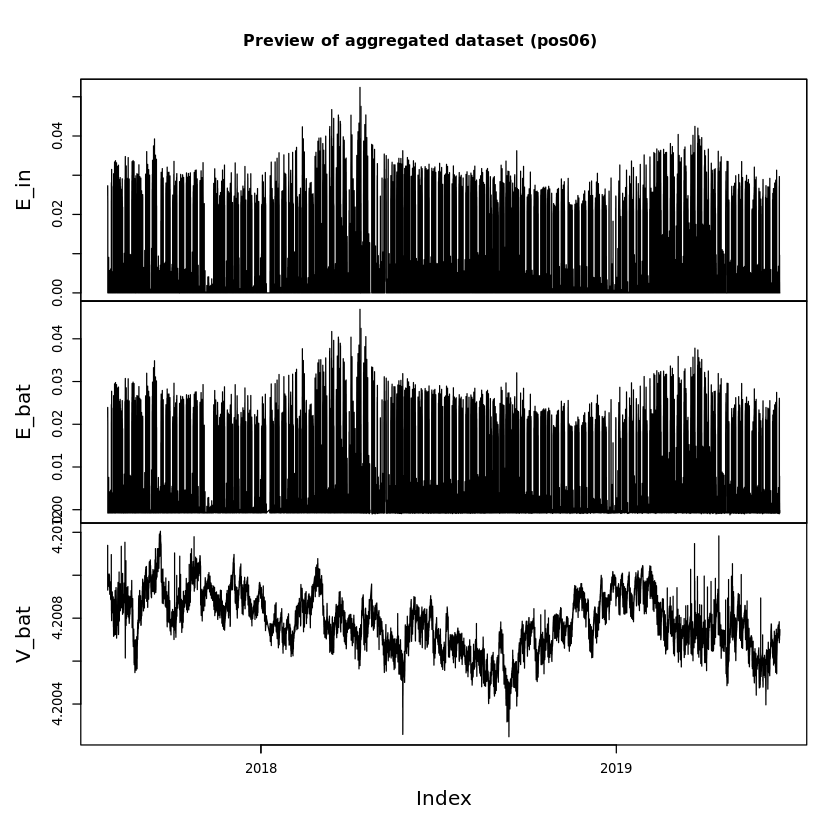

In [12]:
plot(cbind(E_in = power.agg$E_in, E_bat = power.agg$E_bat, V_bat = power.agg$V_bat), main = paste('Preview of aggregated dataset (', position, ')', sep = ''))

## Converter Efficiency Analysis

In [13]:
eta.bq <- pmax(0, power.agg$E_bat / power.agg$E_in)

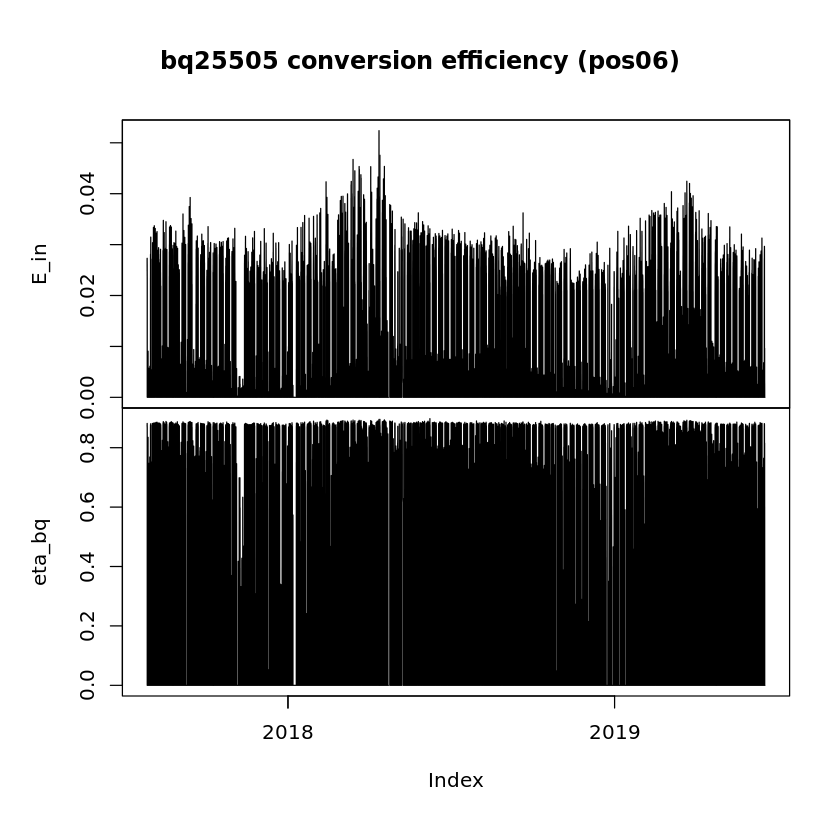

In [14]:
plot(cbind(E_in = power.agg$E_in, eta_bq = eta.bq), main = paste('bq25505 conversion efficiency (', position, ')', sep = ''))

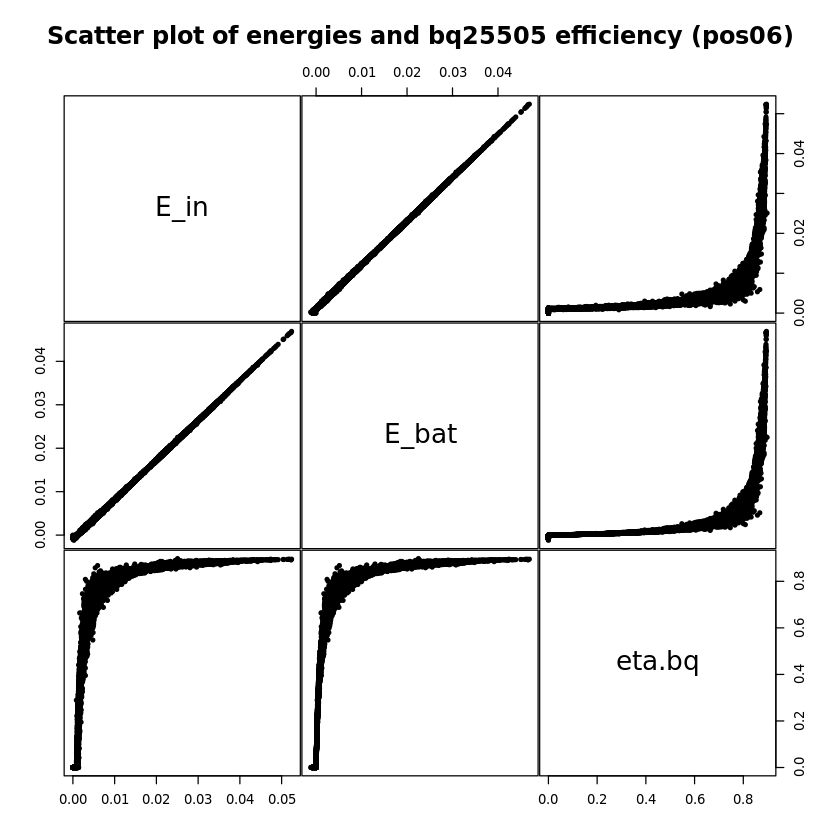

In [15]:
pairs(cbind(power.agg[, c('E_in', 'E_bat')], eta.bq), pch = 20, gap = 0.1, main = paste('Scatter plot of energies and bq25505 efficiency (', position, ')', sep = ''))

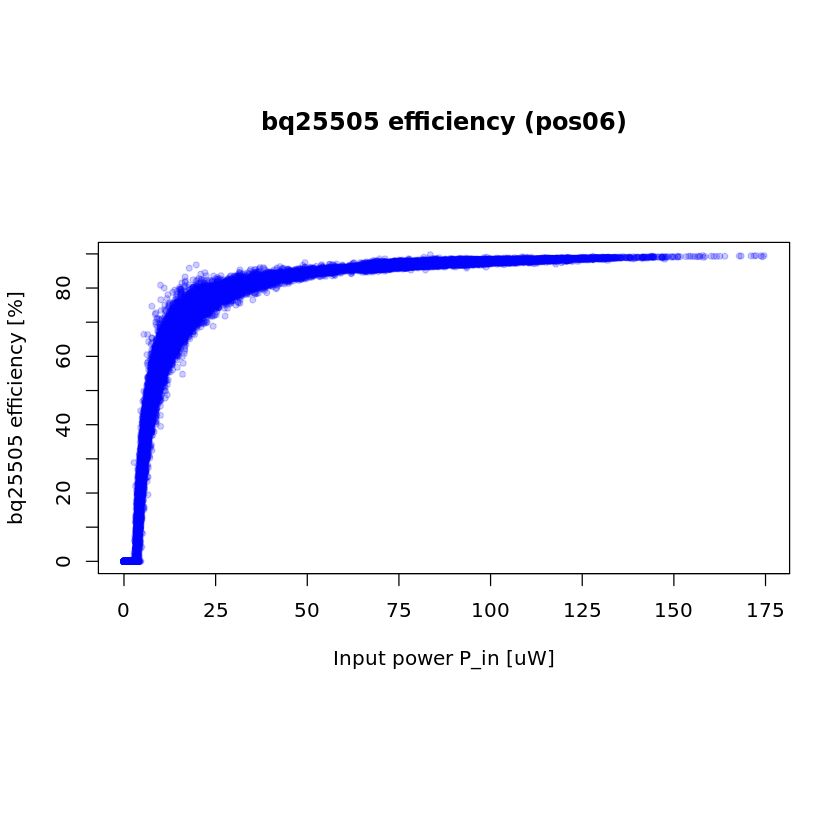

In [16]:
mar.default <- c(5, 4, 4, 2) + 0.1
par(mar = mar.default + c(6, 0, 6, 0))
plot(1e6 * power.agg[, 'P_in'], 100 * eta.bq,
     col = '#0000FF33',
     pch = 20,
     xaxp  = c(0, 200, 8),
     yaxp  = c(0, 90, 9),
     xlab = 'Input power P_in [uW]',
     ylab = 'bq25505 efficiency [%]',
     main = paste('bq25505 efficiency (', position, ')', sep = ''),
)

## Illuminance and Harvested Energy

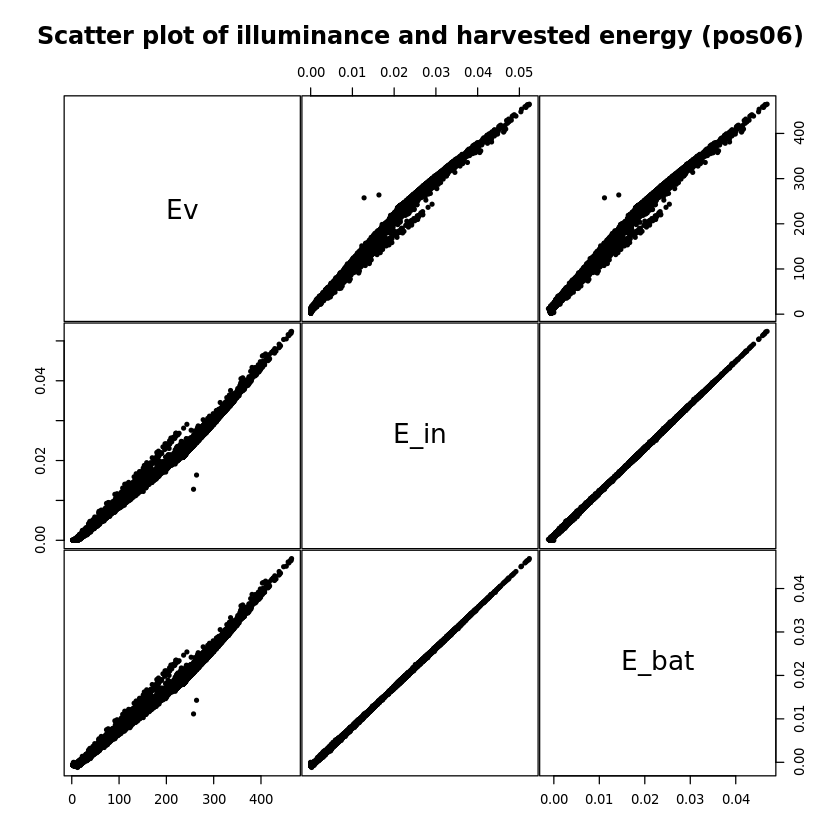

In [17]:
pairs(cbind(Ev = sensor.agg[, 'Ev'], power.agg[, c('E_in', 'E_bat')]), pch = 20, gap = 0.1, main = paste('Scatter plot of illuminance and harvested energy (', position, ')', sep = ''))

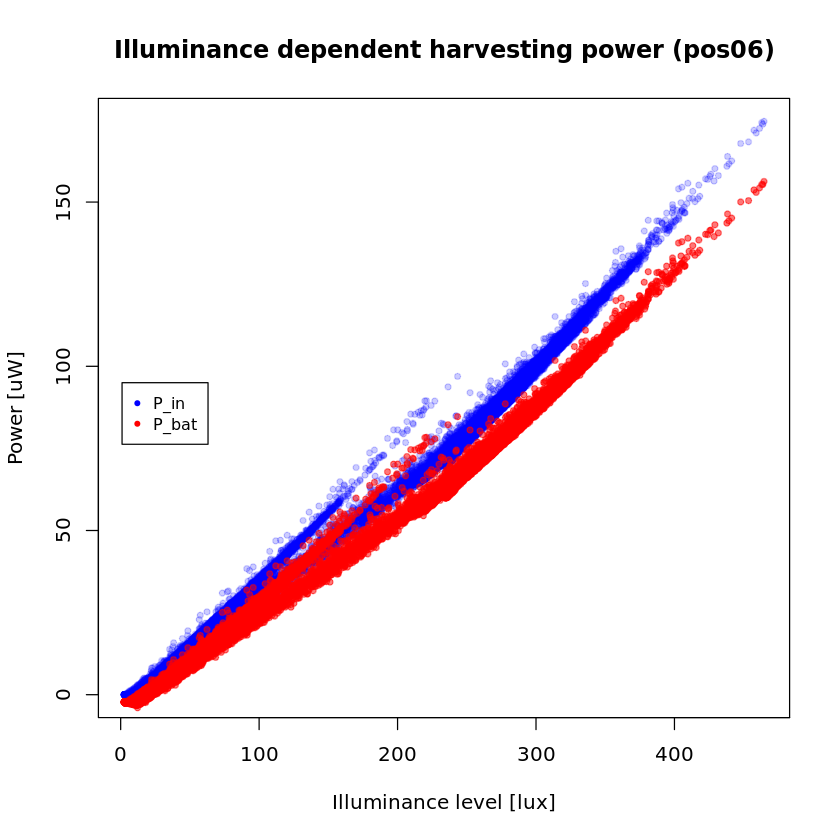

In [18]:
plot(sensor.agg[, 'Ev'], 1e6 * power.agg[, 'P_in'],
     col = '#0000FF33',
     pch = 20,
     xaxp  = c(0, 500, 5),
     xlab = 'Illuminance level [lux]',
     ylab = 'Power [uW]',
     main = paste('Illuminance dependent harvesting power (', position, ')', sep = ''),
)
points(sensor.agg[, 'Ev'], 1e6 * power.agg[, 'P_bat'],
     col = '#FF000088',
     pch = 20,
)
legend(1, 95,
       legend=c('P_in', 'P_bat'),
       pch = 20,
       col=c('blue', 'red'),
       cex=0.8)